In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from merge_module import Split_area
from visualization import  Scatter, Day_plot, NullPlot, TimeBar

# Load data

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/MappingData.csv')
print(df.shape)
df.head()

(129117, 14)


,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,1,0.0,44.0,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,1
1,2013-01-01,전남 목포시,2,0.0,34.0,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,1
2,2013-01-01,전남 목포시,3,0.0,41.0,-2.7,3.6,160.0,95.0,1020.8,NaN,7.0,1800.0,1
3,2013-01-01,전남 목포시,4,0.0,41.0,-2.9,4.0,160.0,94.0,1020.0,NaN,7.0,1800.0,1
4,2013-01-01,전남 목포시,5,0.0,35.0,-2.4,3.0,160.0,91.0,1019.3,NaN,10.0,1200.0,1


In [4]:
area_list = ['전남 목포시', '강원 강릉시', '경남 진주시']
Mp_df, Gn_df, Jj_df = Split_area(df, 'Area', area_list)

전체 : (129117, 14)
['전남 목포시'] : (60796, 14)
['강원 강릉시'] : (35063, 14)
['경남 진주시'] : (33258, 14)


# Delete Nighttime

In [5]:
def Drop_idx(df):
  data = df.copy()
  idx = data[data['Photovoltaics'] == 0].index
  data.drop(idx, inplace=True)
  data.dropna(subset=['Photovoltaics'], inplace=True)
  data.reset_index(inplace=True, drop=True)
  return data

In [6]:
drop_data = Drop_idx(df)

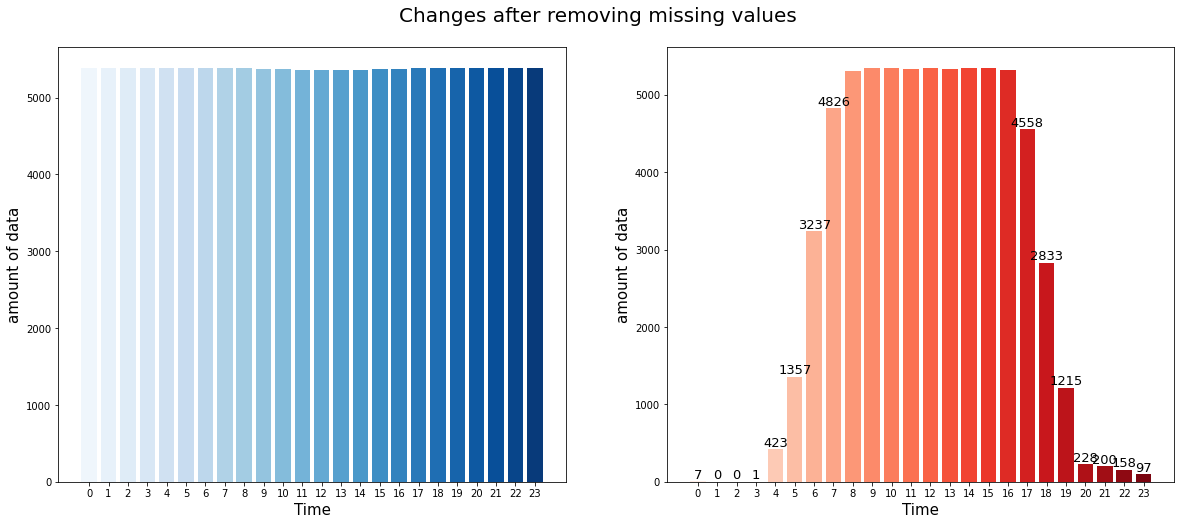

In [7]:
time_df = []
drop_df = []
for h in df['Time'].unique():
  all_df = df[df['Time'] == h]
  drop_null = drop_data[drop_data['Time'] == h]
  time_df.append(len(all_df))
  drop_df.append(len(drop_null))

fig, [ax1,ax2] = plt.subplots(figsize=(20,8), nrows=1, ncols=2)

pal1 = sns.color_palette("Blues", len(time_df))
pal2 = sns.color_palette("Reds", len(drop_df))

plt.suptitle(f'Changes after removing missing values', fontsize=20, y=0.95)
ax1.set_xticks(range(0,24))
ax1.set_xticklabels(range(0,24))
ax1.set_xlabel('Time', fontsize=15)
ax1.set_ylabel('amount of data', fontsize=15)

ax1.bar(range(0,len(time_df)), time_df, color=pal1)
# ax2 = ax1.twinx().twiny()
bar = ax2.bar(range(0,len(drop_df)), drop_df, color=pal2)
ax2.set_xticks(range(0,24))
ax2.set_xticklabels(range(0,24))
ax2.set_xlabel('Time', fontsize=15)
ax2.set_ylabel('amount of data', fontsize=15)

for b in bar:
  x = b.get_x() + b.get_width()/2.0
  y = b.get_height()
  if y <= 5000:
    ax2.text(x, y, y, ha='center', va='bottom', fontsize=13)
plt.show()

In [8]:
def Drop_idx(df, drop_times):
  data = df.copy()
  drop_idx = []
  night_idx = data[data['Time'].isin(drop_times)].index # 밤 시간대 제거
  zero_idx = data[data['Photovoltaics'] == 0].index # 그 외에도 발전량이 0인 행 제거
  drop_idx.extend([i for i in night_idx])
  drop_idx.extend([i for i in zero_idx])
  data.drop(drop_idx, inplace=True)
  data.dropna(subset=['Photovoltaics'], inplace=True)
  data.reset_index(inplace=True, drop=True)
  return data

In [9]:
drop_times = [0,1,2,3,4,21,22,23]
daytime_df = Drop_idx(df, drop_times)
daytime_df

,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,9,20.16,43.0,2.6,6.0,290.0,91.0,1019.6,0.03,10.0,1300.0,1
1,2013-01-01,전남 목포시,10,106.80,56.0,4.2,5.8,250.0,82.0,1019.9,0.57,7.0,1300.0,1
2,2013-01-01,전남 목포시,11,469.56,75.0,3.8,7.1,320.0,80.0,1020.5,1.00,9.0,1300.0,1
3,2013-01-01,전남 목포시,12,504.24,84.0,4.9,2.8,290.0,73.0,1020.1,1.05,7.0,1300.0,1
4,2013-01-01,전남 목포시,13,745.20,78.0,5.2,6.7,320.0,66.0,1019.7,1.14,6.0,1100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66470,2020-11-15,경남 진주시,17,1.00,NaN,16.5,1.3,180.0,53.0,1025.2,0.34,0.0,2000.0,11
66471,2020-11-16,경남 진주시,6,1.00,NaN,3.5,0.2,0.0,97.0,1026.6,NaN,9.0,432.0,11
66472,2020-11-16,경남 진주시,7,13.00,NaN,3.8,0.0,0.0,97.0,1026.6,NaN,10.0,578.0,11
66473,2020-11-16,경남 진주시,8,40.00,NaN,4.9,0.0,0.0,97.0,1026.9,0.11,8.0,565.0,11


In [10]:
daytime_df['Time'].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  8, 19,  7, 20,  6,  5])

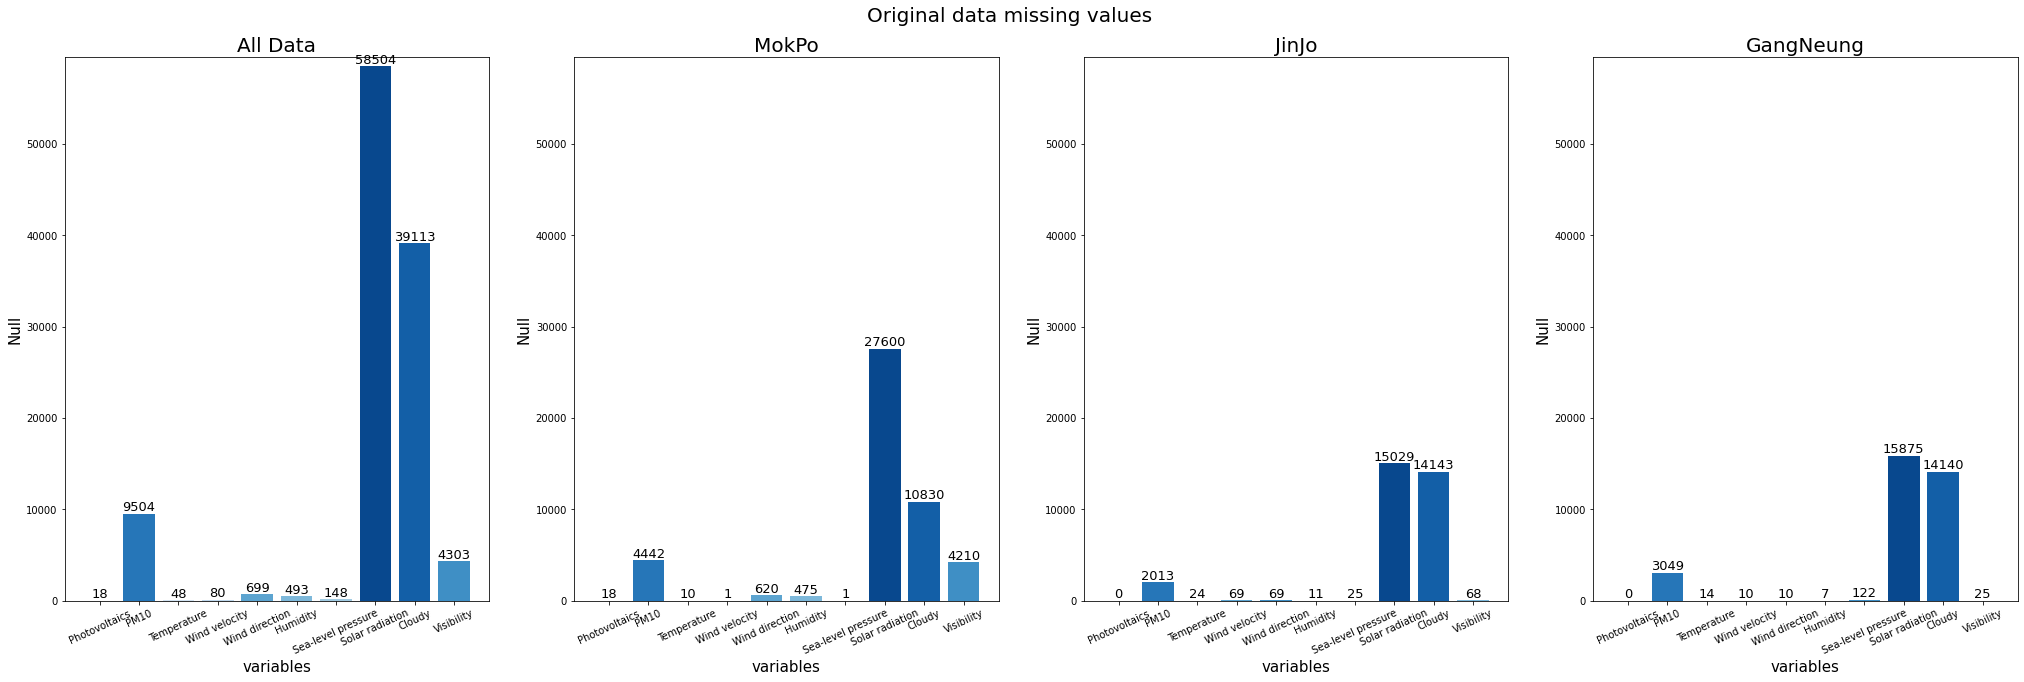

In [11]:
df_list = [df, Mp_df, Jj_df, Gn_df]
NullPlot(df, df_list, 'Original data missing values')

In [12]:
area_list = ['전남 목포시', '강원 강릉시', '경남 진주시']
Mp_df, Gn_df, Jj_df = Split_area(daytime_df, 'Area', area_list)

전체 : (66475, 14)
['전남 목포시'] : (30944, 14)
['강원 강릉시'] : (17671, 14)
['경남 진주시'] : (17860, 14)


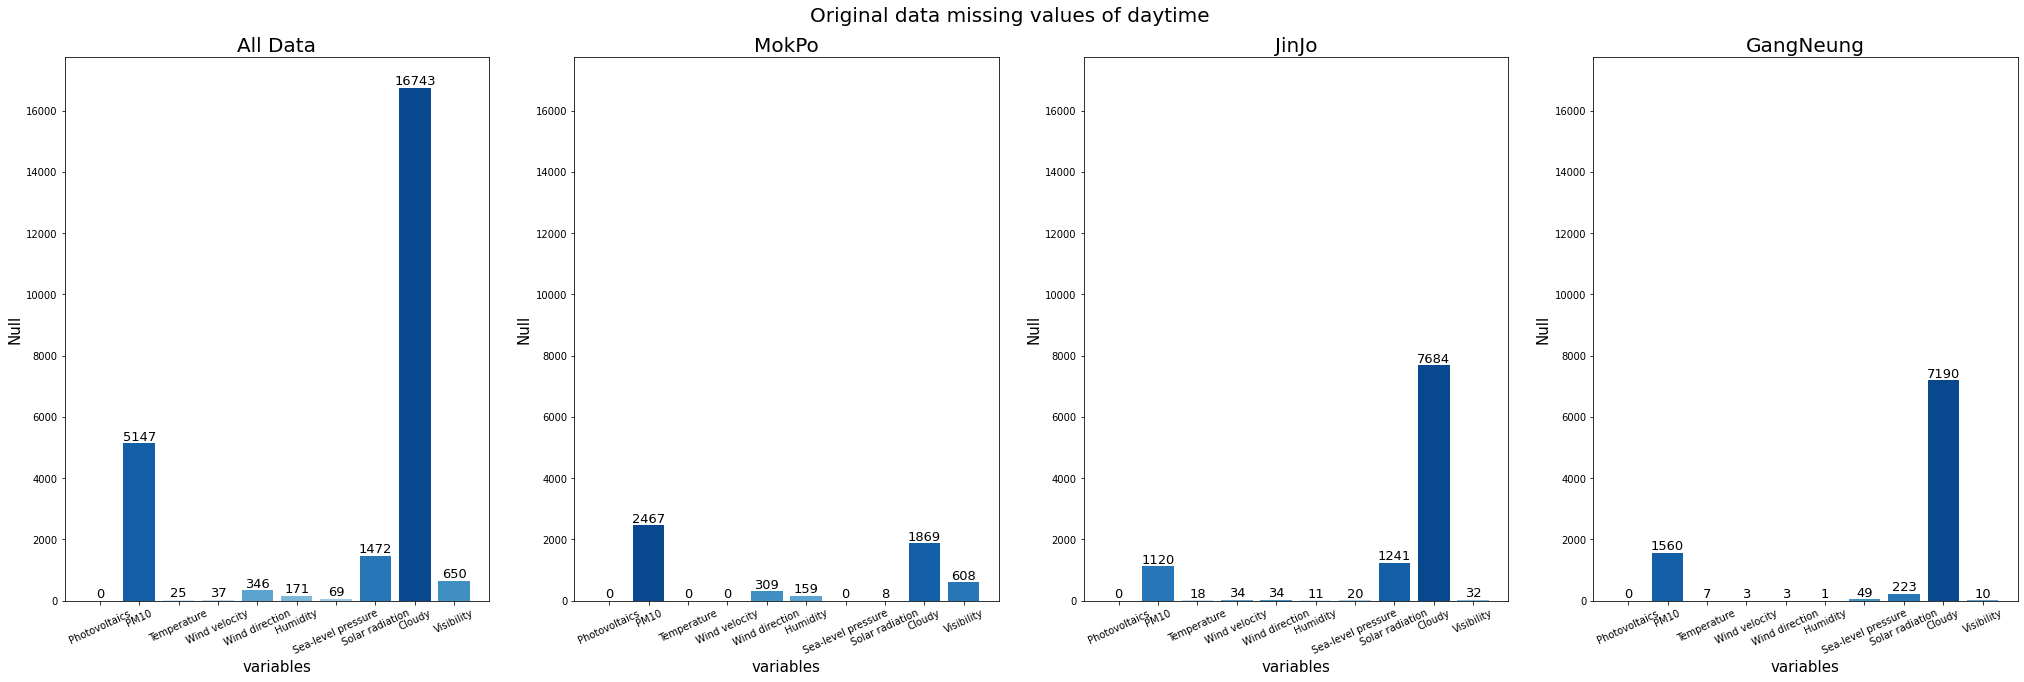

In [13]:
df_list = [daytime_df, Mp_df, Jj_df, Gn_df]
NullPlot(daytime_df, df_list, 'Original data missing values of daytime')

# Distribution of Area

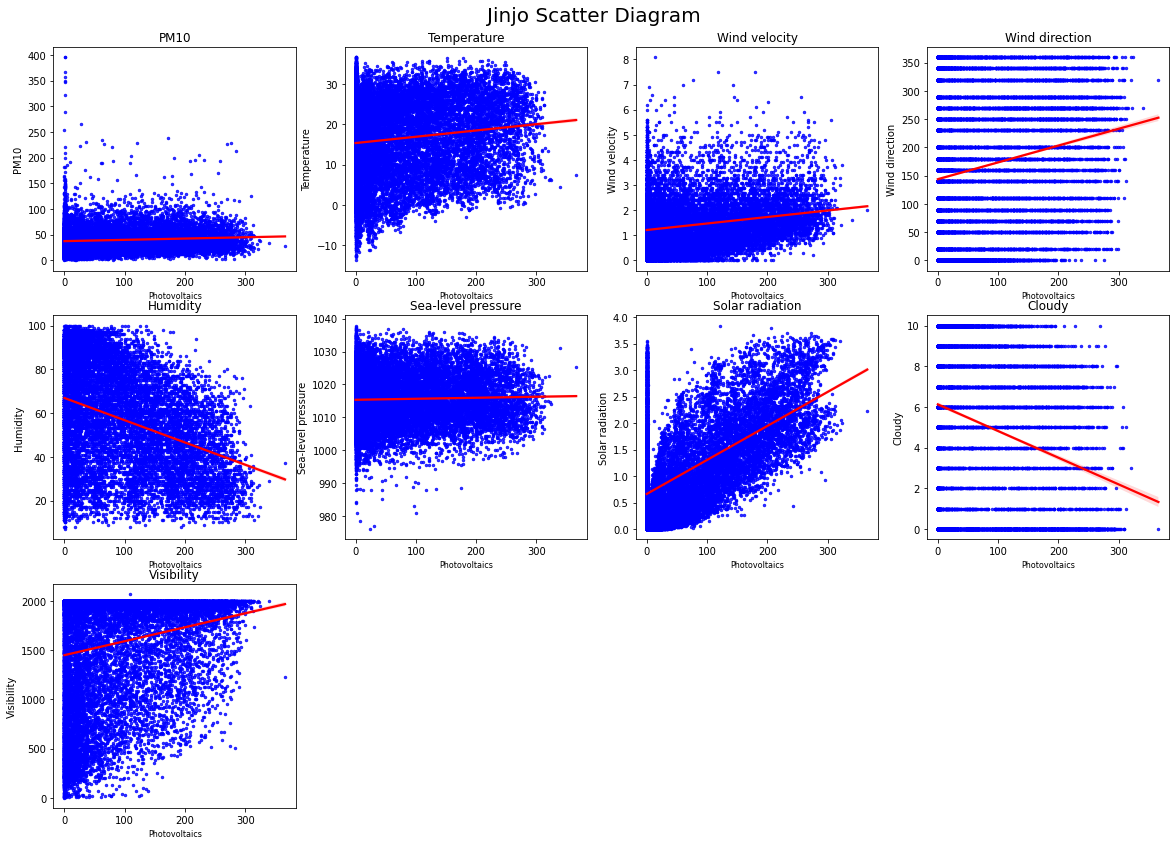

In [14]:
Scatter(Jj_df, 'Photovoltaics', "Jinjo")

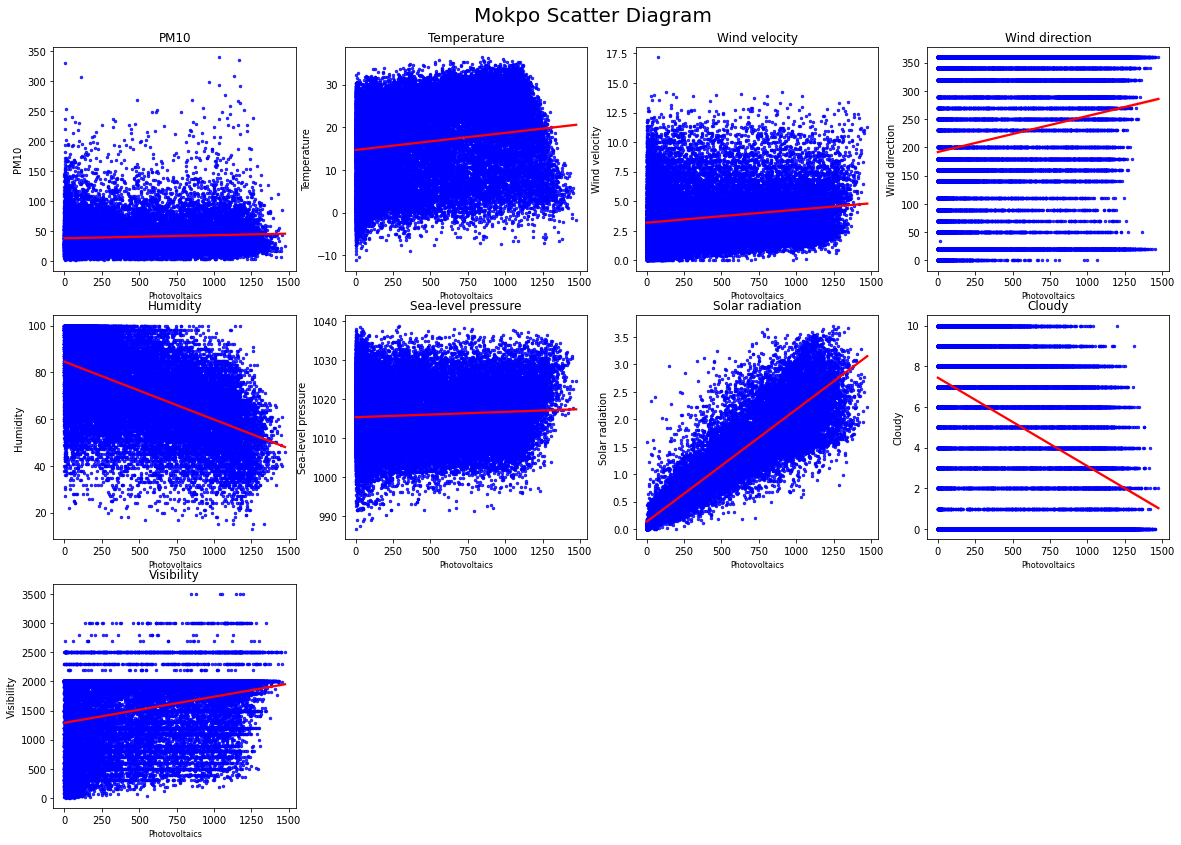

In [15]:
Scatter(Mp_df, 'Photovoltaics',  "Mokpo")

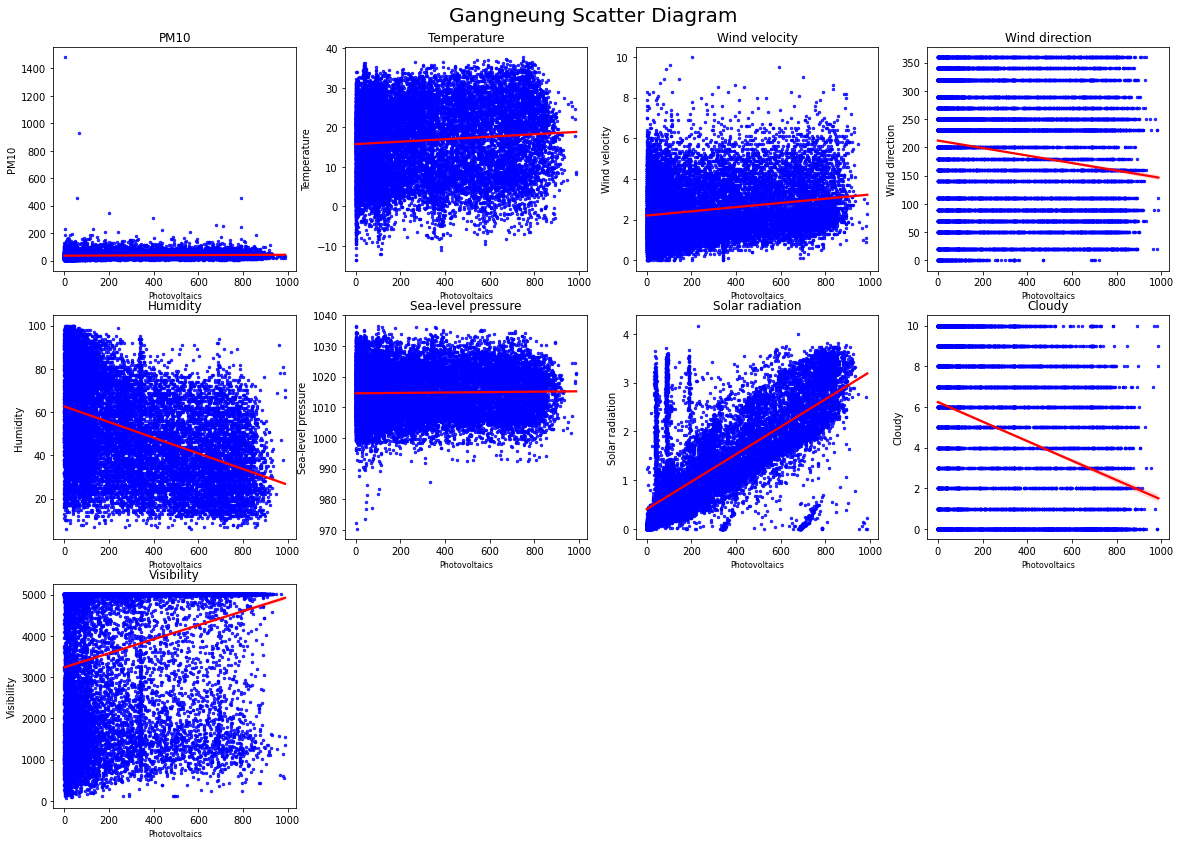

In [16]:
Scatter(Gn_df, 'Photovoltaics', "Gangneung")

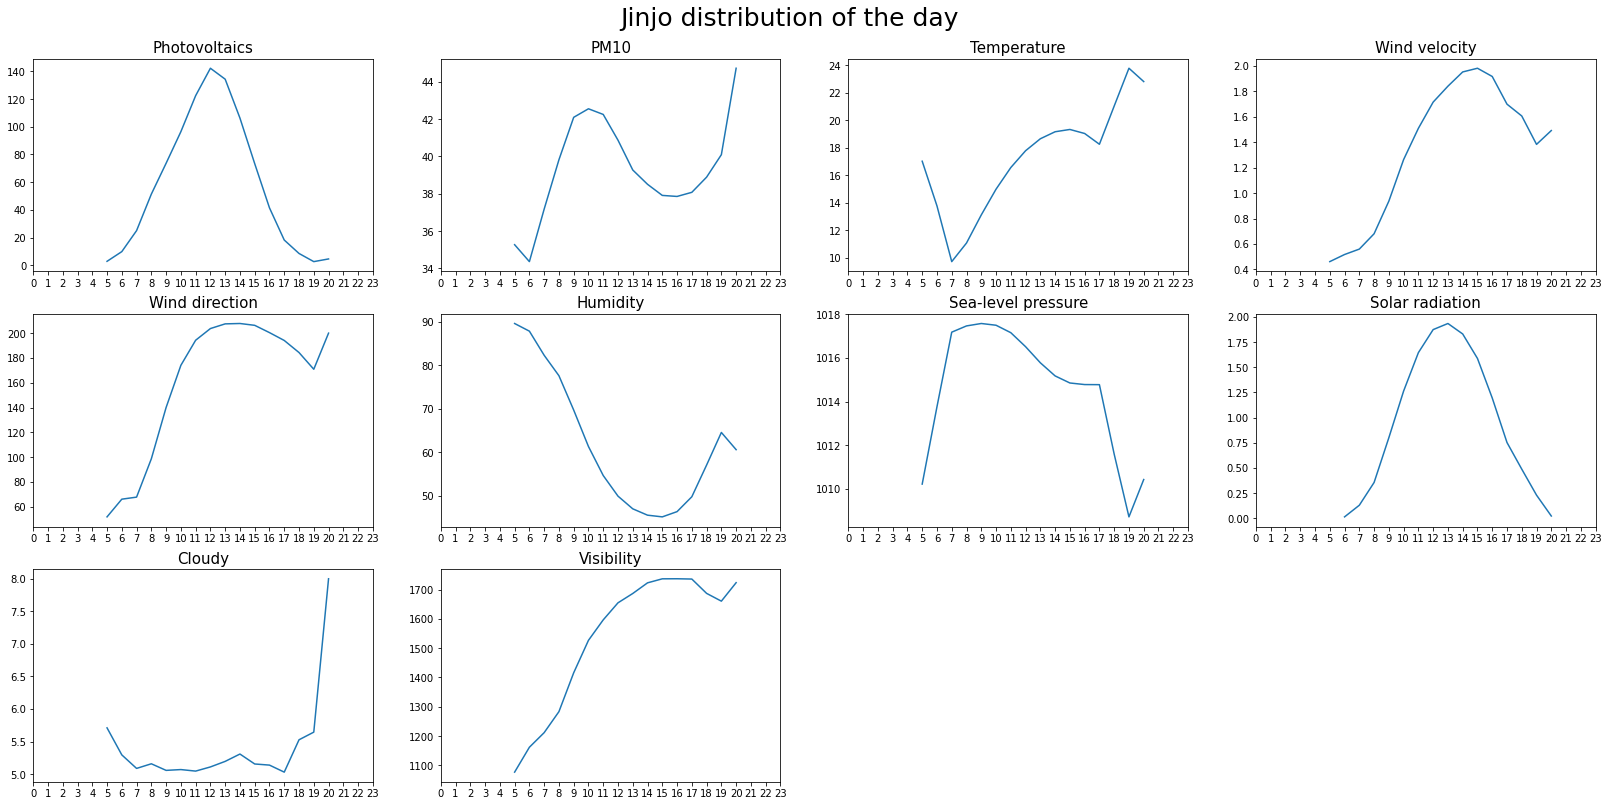

In [17]:
Day_plot(Jj_df, 'Jinjo')

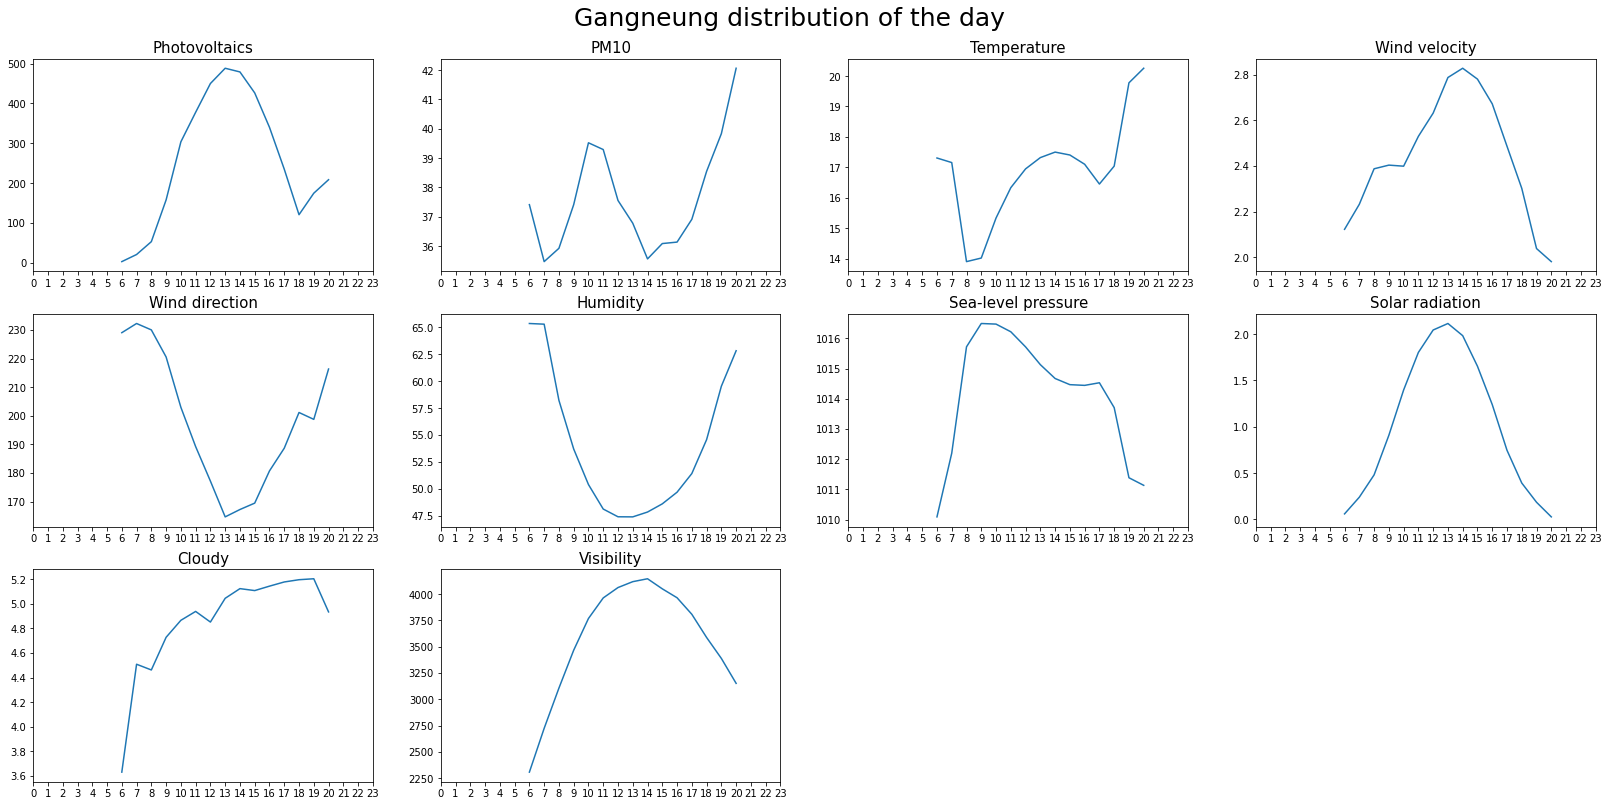

In [18]:
Day_plot(Gn_df, 'Gangneung')

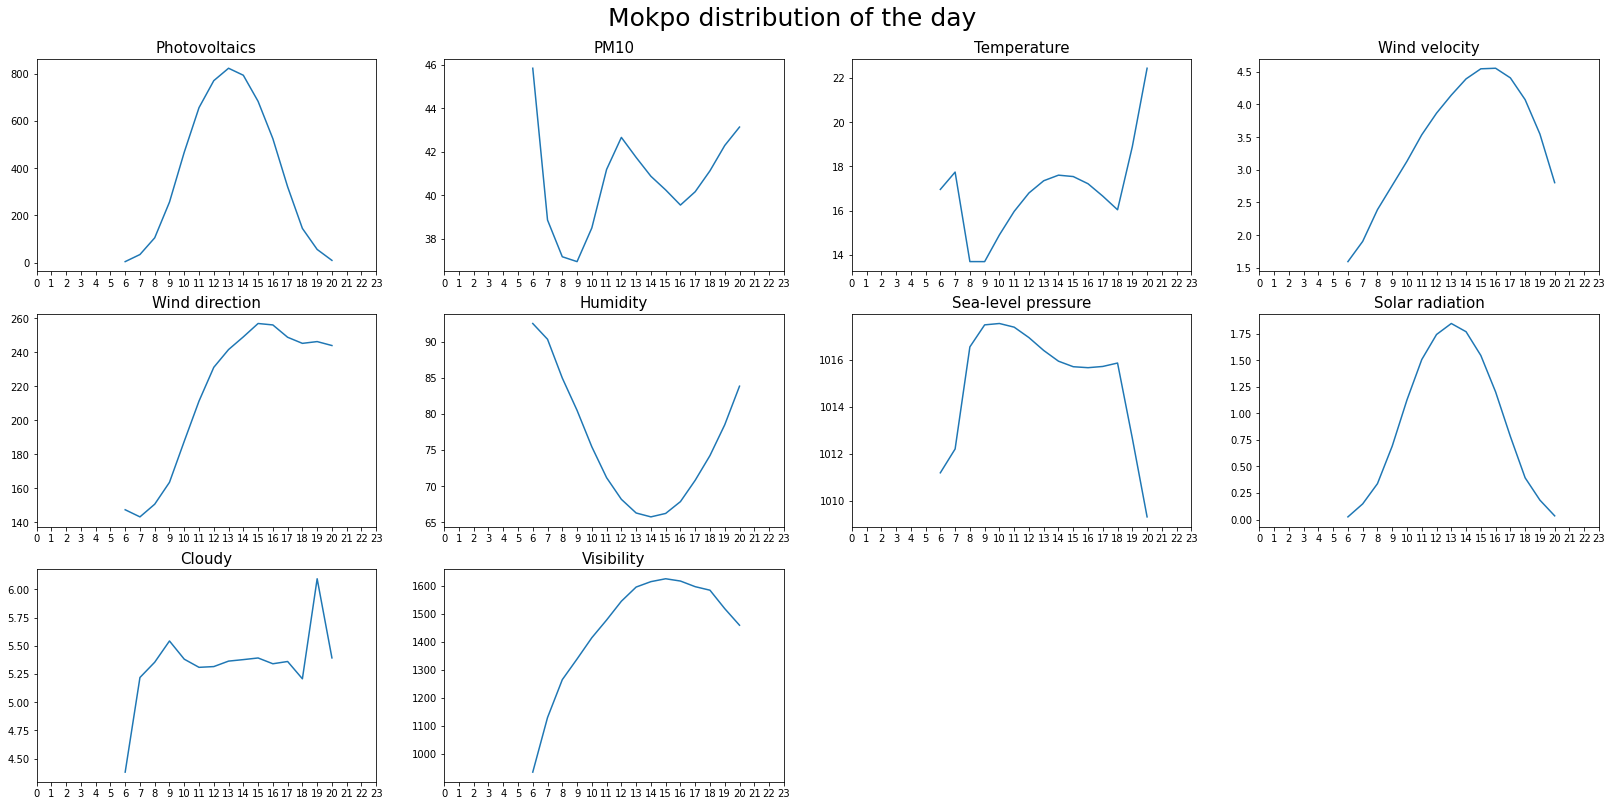

In [19]:
Day_plot(Mp_df, 'Mokpo')

In [20]:
Mp_df

,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,9,20.16,43.0,2.6,6.0,290.0,91.0,1019.6,0.03,10.0,1300.0,1
1,2013-01-01,전남 목포시,10,106.80,56.0,4.2,5.8,250.0,82.0,1019.9,0.57,7.0,1300.0,1
2,2013-01-01,전남 목포시,11,469.56,75.0,3.8,7.1,320.0,80.0,1020.5,1.00,9.0,1300.0,1
3,2013-01-01,전남 목포시,12,504.24,84.0,4.9,2.8,290.0,73.0,1020.1,1.05,7.0,1300.0,1
4,2013-01-01,전남 목포시,13,745.20,78.0,5.2,6.7,320.0,66.0,1019.7,1.14,6.0,1100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30939,2019-12-31,전남 목포시,14,1148.52,24.0,-1.5,9.1,360.0,59.0,1033.5,1.04,7.0,2000.0,12
30940,2019-12-31,전남 목포시,15,830.88,21.0,-1.5,9.9,360.0,55.0,1033.6,1.43,6.0,2000.0,12
30941,2019-12-31,전남 목포시,16,550.92,20.0,-1.7,8.9,360.0,60.0,1034.0,0.86,7.0,2000.0,12
30942,2019-12-31,전남 목포시,17,74.28,22.0,-1.9,8.8,360.0,61.0,1034.3,0.39,6.0,2000.0,12


In [21]:
Gn_df

,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2017-01-01,강원 강릉시,9,75.552,64.0,5.4,4.4,290.0,38.0,1027.1,0.32,NaN,4816.0,1
1,2017-01-01,강원 강릉시,10,306.528,70.0,6.8,4.9,290.0,33.0,1027.2,0.94,NaN,5010.0,1
2,2017-01-01,강원 강릉시,11,492.672,75.0,7.6,6.4,290.0,31.0,1027.4,1.41,NaN,5010.0,1
3,2017-01-01,강원 강릉시,12,622.176,75.0,8.1,5.9,320.0,33.0,1026.4,1.67,NaN,5010.0,1
4,2017-01-01,강원 강릉시,13,498.048,75.0,8.7,5.2,320.0,35.0,1025.6,1.38,NaN,4307.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17666,2020-12-31,강원 강릉시,15,401.280,16.0,0.3,4.5,230.0,27.0,1019.1,1.47,0.0,5000.0,12
17667,2020-12-31,강원 강릉시,16,382.464,13.0,-0.1,4.0,230.0,29.0,1019.2,0.94,0.0,5000.0,12
17668,2020-12-31,강원 강릉시,17,150.048,20.0,-1.8,4.0,250.0,34.0,1019.5,0.36,0.0,5000.0,12
17669,2020-12-31,강원 강릉시,19,320.352,22.0,-4.0,5.4,230.0,40.0,1020.0,NaN,0.0,4333.0,12


In [22]:
Jj_df

,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2017-01-01,경남 진주시,7,4.0,45.0,-4.4,0.0,0.0,89.0,1030.5,NaN,NaN,560.0,1
1,2017-01-01,경남 진주시,8,28.0,51.0,-4.0,0.1,0.0,89.0,1031.0,0.00,NaN,547.0,1
2,2017-01-01,경남 진주시,9,59.0,56.0,-1.9,0.0,0.0,89.0,1031.5,0.22,NaN,619.0,1
3,2017-01-01,경남 진주시,10,125.0,58.0,1.4,0.0,0.0,88.0,1031.8,0.44,NaN,705.0,1
4,2017-01-01,경남 진주시,11,174.0,62.0,4.8,0.6,200.0,69.0,1030.9,0.97,NaN,1103.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17855,2020-11-15,경남 진주시,17,1.0,NaN,16.5,1.3,180.0,53.0,1025.2,0.34,0.0,2000.0,11
17856,2020-11-16,경남 진주시,6,1.0,NaN,3.5,0.2,0.0,97.0,1026.6,NaN,9.0,432.0,11
17857,2020-11-16,경남 진주시,7,13.0,NaN,3.8,0.0,0.0,97.0,1026.6,NaN,10.0,578.0,11
17858,2020-11-16,경남 진주시,8,40.0,NaN,4.9,0.0,0.0,97.0,1026.9,0.11,8.0,565.0,11


# Final Data
Remove missing values

In [23]:
data = daytime_df.dropna(how='any') # 데이터의 결측치 모두 제거
data.reset_index(inplace=True, drop=True)
data.shape 

(43771, 14)

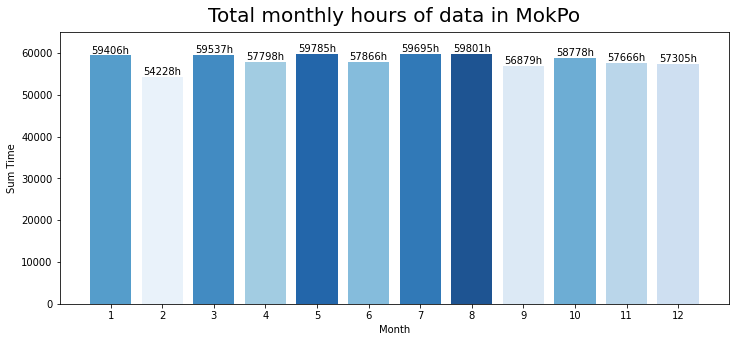

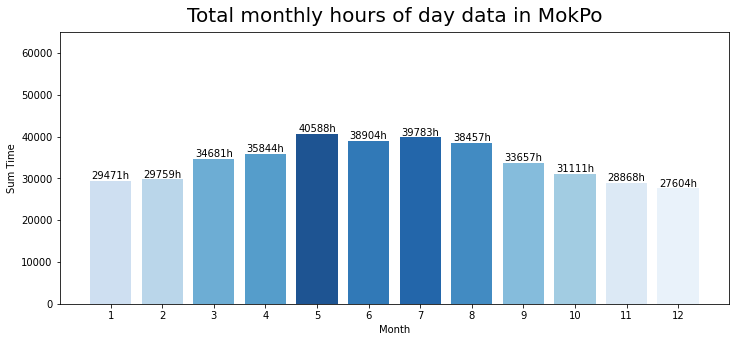

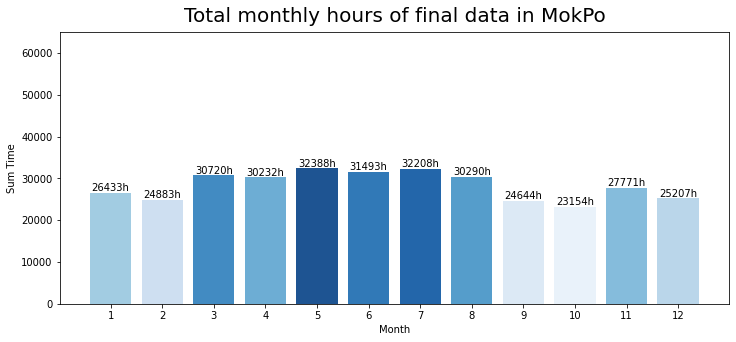

In [26]:
TimeBar(df, '전남 목포시', 'data in MokPo', [0, 65000])
TimeBar(daytime_df, '전남 목포시', 'day data in MokPo', [0, 65000])
TimeBar(data, '전남 목포시', 'final data in MokPo', [0, 65000])

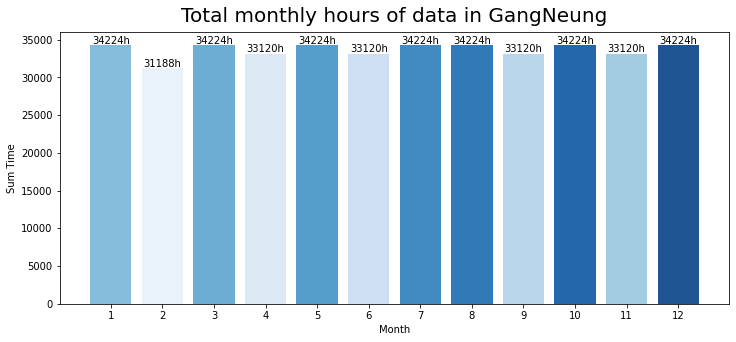

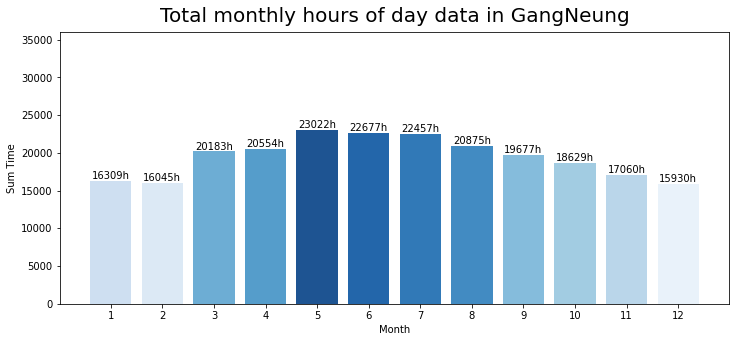

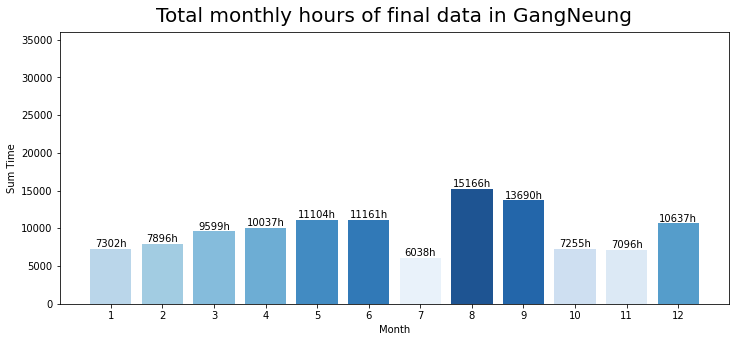

In [27]:
TimeBar(df, '강원 강릉시', 'data in GangNeung', [0,36000])
TimeBar(daytime_df, '강원 강릉시', 'day data in GangNeung', [0,36000])
TimeBar(data, '강원 강릉시', 'final data in GangNeung', [0,36000])

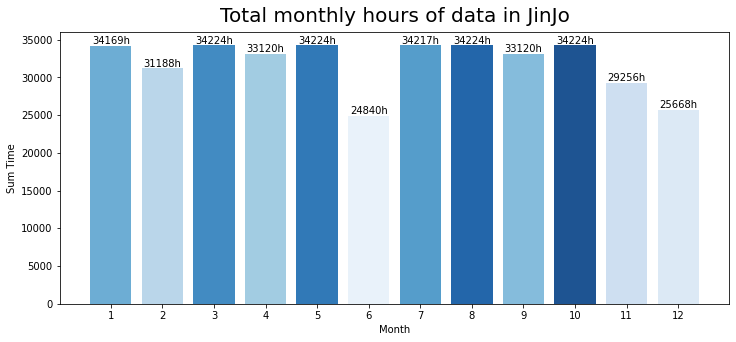

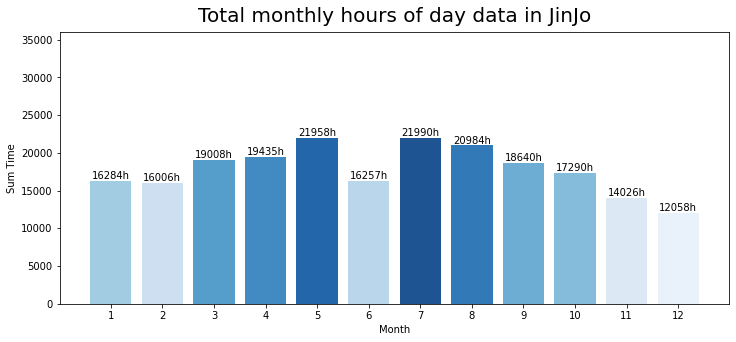

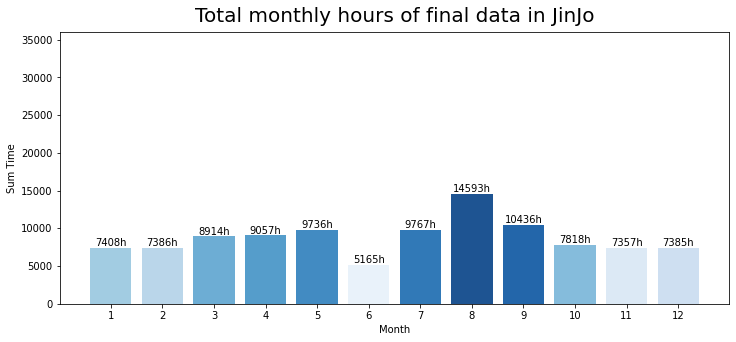

In [28]:
TimeBar(df, '경남 진주시', 'data in JinJo', [0,36000])
TimeBar(daytime_df, '경남 진주시', 'day data in JinJo', [0,36000])
TimeBar(data, '경남 진주시', 'final data in JinJo', [0,36000])

# Save data


In [34]:
data

,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,9,20.16,43.0,2.6,6.0,290.0,91.0,1019.6,0.03,10.0,1300.0,1
1,2013-01-01,전남 목포시,10,106.80,56.0,4.2,5.8,250.0,82.0,1019.9,0.57,7.0,1300.0,1
2,2013-01-01,전남 목포시,11,469.56,75.0,3.8,7.1,320.0,80.0,1020.5,1.00,9.0,1300.0,1
3,2013-01-01,전남 목포시,12,504.24,84.0,4.9,2.8,290.0,73.0,1020.1,1.05,7.0,1300.0,1
4,2013-01-01,전남 목포시,13,745.20,78.0,5.2,6.7,320.0,66.0,1019.7,1.14,6.0,1100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43766,2020-09-16,경남 진주시,17,18.00,33.0,22.8,0.8,140.0,86.0,1009.0,0.53,10.0,1988.0,9
43767,2020-09-16,경남 진주시,18,2.00,36.0,22.7,1.0,110.0,89.0,1008.4,0.25,5.0,1738.0,9
43768,2020-09-17,경남 진주시,7,9.00,31.0,21.0,0.5,340.0,97.0,1011.3,0.01,10.0,631.0,9
43769,2020-09-17,경남 진주시,8,13.00,29.0,20.8,0.5,20.0,96.0,1011.6,0.06,10.0,916.0,9


In [35]:
area_list = ['전남 목포시', '강원 강릉시', '경남 진주시']
Mp_df, Gn_df, Jj_df = Split_area(data, 'Area', area_list)

전체 : (43771, 14)
['전남 목포시'] : (26389, 14)
['강원 강릉시'] : (8908, 14)
['경남 진주시'] : (8474, 14)


In [37]:
Mp_df['Area'].unique()

array(['전남 목포시'], dtype=object)

In [38]:
Gn_df['Area'].unique()

array(['강원 강릉시'], dtype=object)

In [39]:
Jj_df['Area'].unique()

array(['경남 진주시'], dtype=object)

In [40]:
data.to_csv('/content/gdrive/MyDrive/SolarPower/TestData.csv', index=None) # 밤 시간대, 결측치 제거 데이터
Mp_df.to_csv('/content/gdrive/MyDrive/SolarPower/Mpdata.csv', index=None) 
Gn_df.to_csv('/content/gdrive/MyDrive/SolarPower/Gndata.csv', index=None) 
Jj_df.to_csv('/content/gdrive/MyDrive/SolarPower/Jjdata.csv', index=None) 